# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

 <a id='libraries'></a>
## Import Libraries

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For technical analysis
import talib as ta

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

#ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# We import the pickle library to save and load models on the local machine
import pickle

import warnings 
warnings.filterwarnings('ignore')

<a id='data'></a>
## Read the Data

Import the file `spy_daily_2009_2022.csv` using the `read_csv` method of `pandas`. This file has the OHLCV values for SPY in the daily frequency. This CSV file is available in the zip file of the unit 'Python Codes and Data' in the 'Course Summary' section.

In [2]:
# Import the SPY daily data
spy = pd.read_csv('../data_modules/spy_daily_2009_2022.csv', index_col=0)

# Change the index type to datetime
spy.index = pd.to_datetime(spy.index)

# Display the data
spy.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-06-23,373.384588,375.555631,369.667000,374.792297,79292100
2022-06-24,378.103436,386.718328,378.073696,386.708405,98050300
2022-06-27,387.670022,387.977340,384.091239,385.231293,66009600
2022-06-28,386.857107,389.761775,377.240936,377.359894,86548900
2022-06-29,377.934904,378.965893,375.149194,377.052582,65676000


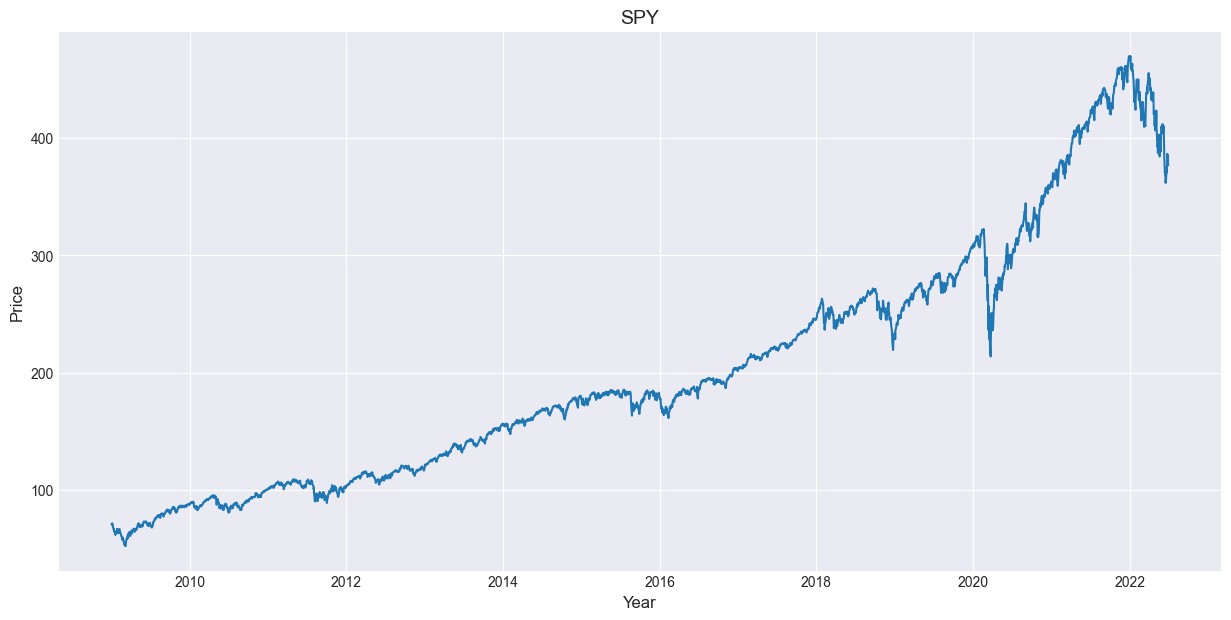

In [3]:
# Plot the data to visualize it
plt.figure(figsize=(15, 7))
plt.plot(spy.index, spy.Close)

# Set the title and axes labels
plt.title('SPY', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

## Create a function to generate the features

In the previous sections, we have created features directly using the dataframe, here we will be using a function that will take the dataframe as input and return the features. While performing a simulation we will need to create the features at every data point, so to perform this repetitive task we create a function which will be called whenever we need to create the features.


In [4]:
# This function takes the raw data as its input

def create_features(data):
    # Define time periods to calculate returns
    intervals = [1, 5, 10, 22, 44, 88]

    # Loop to calculate returns for time periods specified in 'intervals'
    for t in intervals:
        # Create new columns for features in 'data' and store the value of returns
        data[f'f_ret_{t}'] = data.Close.pct_change(t)

    # Calculate and store the NATR values
    data['f_natr'] = ta.NATR(data.High, data.Low, data.Close)

    # Calculate and store the RSI values
    data['f_rsi'] = ta.RSI(data.Close)

    # Compute the Bollinger bands
    upper, middle, lower = ta.BBANDS(data.Close)

    # Normalise the bands and store in separate columns
    data['f_norm_upper'] = upper/data.Close
    data['f_norm_lower'] = lower/data.Close
    data['f_norm_middle'] = middle/data.Close
    data = data.dropna()

    # Create the target variable
    data['return'] = data.Close.pct_change(1).shift(-1)
    data['target'] = np.where(data['return'] > 0, 1, 0)

    X = data.filter(like='f_')
    y = data['target']
    return X, y

In [5]:
# Call the function to generate the datasets
X, y = create_features(spy)

#### Decide the simulation parameters

We decide the length of the data that will be used to perform the simulation

In [6]:
simulation_length = 252

#### Calculate the minimum data needed to generate one data point

We have used the dropna function in the create_features function earlier. This will result in dropping those first few rows in the dataset that contain null values in the feature data. We have seen earlier that the first 20 rows get dropped when we create the features. So we need to include the past 20 rows of data to generate all features for a single data point. 

In case, if you want to add more features this value would keep changing. To solve this problem, we have added a simple variable called minimum_feature_length that will give us the minimum number of data points needed to make a prediction for one data point.

In [7]:
# Here we add one to represent the one data point that would have all the features after dropping the null values
minimum_feature_length = len(spy)-len(X)+1
minimum_feature_length

89

### Decide the past performance parameter

While performing the simulation we need to check the past performance of the model. So, we create a variable called performance_length to assign this value to it. Here we will check the performance of the model over the past 20 data points

In [8]:
performance_length = 20

In [9]:
minimum_feature_length, simulation_length, performance_length

(89, 252, 20)

### Split the data to train and simulation

Now, we will split the initial raw data loaded from the local machine into two datasets:

1. Train --------> data_train   
2. Simulation--> data_sim

In [10]:
# Create the simulation data we need the minimum length of data to create one data point with all features. So we need at least
# minimum_feature_length of data.
# Since we also need to measure the past performance for every data point in the simulation, we need to include
# performance_length of data for a single data point in the simulation.
# Finally, we need to perform the simulation on data points to equal the length to a variable simulation_length.
data_sim = spy[-(minimum_feature_length +
                 performance_length+simulation_length):].copy()

# Assign the remaining data to train dataset
data_train = spy[:-(minimum_feature_length +
                    performance_length+simulation_length)].copy()

# Create the features and target datasets for the train data. We will use these to create our initial model,
# which we would be using to begin the simulation with.
X, y = create_features(data_train)

### Create a function to train a model

We will be training multiple models when performing the simulation. So we create a function called train_model to handle this repetitive step. This function takes the feature(X) and target(y) datasets as its input and returns a trained model. 

In [11]:
def train_model(X, y):
    
    # Instantiate the Machine Learning model
    model = DecisionTreeClassifier(
        max_depth=5, min_samples_leaf=5, random_state=42)
    
    # Fit the data to the model to train it
    model.fit(X, y)
    
    # Return the model as output
    return model


model = train_model(X, y)

### Create a function to save a model

In a simulation, we will be saving the trained model multiple times. So we create a function called save_model to handle this repetitive step. This function takes the model name and model's saved name as its input and saves the model on the local machine. 

In [12]:
def save_model(model_name, model_saved_name):

    # Open a file with the mentioned name on the local machine
    with open(model_saved_name, 'wb') as model_save:

        # Use the dump command to save it
        pickle.dump(model_name, model_save)

model_saved_name = 'model_save.pkl'
save_model(model, model_saved_name)

### Create a function to load a model

We will be loading the trained model at every data point. So we create a function called load_model to handle this repetitive step. This function takes the model's saved name as its input and loads the model from the local machine. 

In [13]:
def load_model(model_saved_name):
    
    # Open the file containing the model with the mentioned name on the local machine
    with open(model_saved_name, 'rb') as file:
        
        # Load the model and assign it to a variable
        model = pickle.load(file)
        
        # Return the model
        return model

### Retrain the model

We need to retrain a model whenever its performance goes bad. When retraining a model, we need to perform the tasks of creating the features, loading the model and saving the final model on the local machine. To do these multiple tasks, we created a simple function called create_new_model. This function takes the raw data and the saved name of the model as input.

In [14]:
def create_new_model(data, model_saved_name):
    
    # Create feature from the raw data
    X, y = create_features(data)
    
    # Train the model on the features generated
    model = train_model(X, y)
    
    # Save the model on the local machine
    save_model(model, model_saved_name)

### Perform the simulation

We start the simulation by leaving the initial data points needed to avoid the data leakage and then creating the features for the simulation data. For every iteration, we move one data point at a time and then load the past data, perform the feature creation, and model performance analysis.

In [15]:
# Create a list to save the performance during the simulation
strategy_perf = []
for i in range(simulation_length):
    # Load enough past data points to check the performance and to create features for the these past data points.
    # The features of the last data point in the dataset past_data
    # will be used to make a prediction if the past performance of the model is good.
    past_data = data_sim[i:i+minimum_feature_length+performance_length]
    print('Simulating for ', past_data.index[-1].date())
    
    # Create the features and targets over the past_data
    X, y = create_features(past_data)
    
    # Load model from the local machine
    model = load_model(model_saved_name)
    
    # Predict using the loaded model
    predictions = model.predict(X)
    
    # Check of the model's performance over the performance_length
    accuracy = accuracy_score(y.iloc[:-1], predictions[:-1])
    
    # If the performance is satisfactory then use the prediction on the last data point
    if accuracy > 0.55:
        print("Strategy's past performance is good")
        print("Today's trading signal is: {}".format(
            "Buy" if predictions[-1] > 0 else "Sell"))
        print('-----------------------------')
        # Add the prediction of the model to the list strategy_perf, we will use this to check the strategy's performance
        strategy_perf.append(predictions[-1])
    else:
        print("Strategy's past performance is bad")
        print("Retraining the model")
        print("Not trading for today")
        print('-----------------------------')
        
        # Since we wont be training at this data point, we will adding 0 to the list strategy_perf
        strategy_perf.append(0)
        
        # Create a copy of the new train data by rolling forward the train data set by the iteration value
        # As we move forward in the simulation the old data that doesn't over lap with the current simulation data
        # can be added to the train data
        data = data_train[i:-(minimum_feature_length +
                              performance_length+simulation_length)+i].copy()
        
        # Re-train the model and create a new model using the 'data'
        create_new_model(data, model_saved_name)

Simulating for  2021-06-29
Strategy's past performance is good
Today's trading signal is: Buy
-----------------------------
Simulating for  2021-06-30
Strategy's past performance is good
Today's trading signal is: Buy
-----------------------------
Simulating for  2021-07-01
Strategy's past performance is good
Today's trading signal is: Buy
-----------------------------
Simulating for  2021-07-02
Strategy's past performance is good
Today's trading signal is: Buy
-----------------------------
Simulating for  2021-07-06
Strategy's past performance is good
Today's trading signal is: Buy
-----------------------------
Simulating for  2021-07-07
Strategy's past performance is good
Today's trading signal is: Buy
-----------------------------
Simulating for  2021-07-08
Strategy's past performance is good
Today's trading signal is: Buy
-----------------------------
Simulating for  2021-07-09
Strategy's past performance is good
Today's trading signal is: Buy
-----------------------------
Simulati

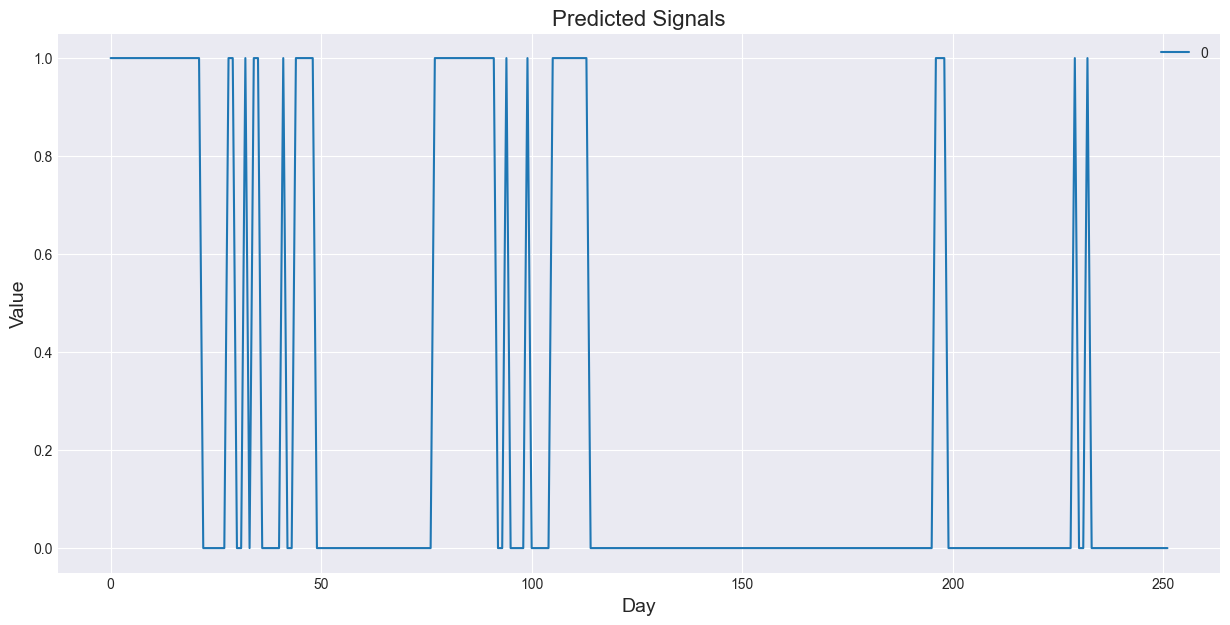

In [16]:
pd.DataFrame(strategy_perf).plot(figsize=(15, 7))

# Set the title and axes labels
plt.title('Predicted Signals', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.show()

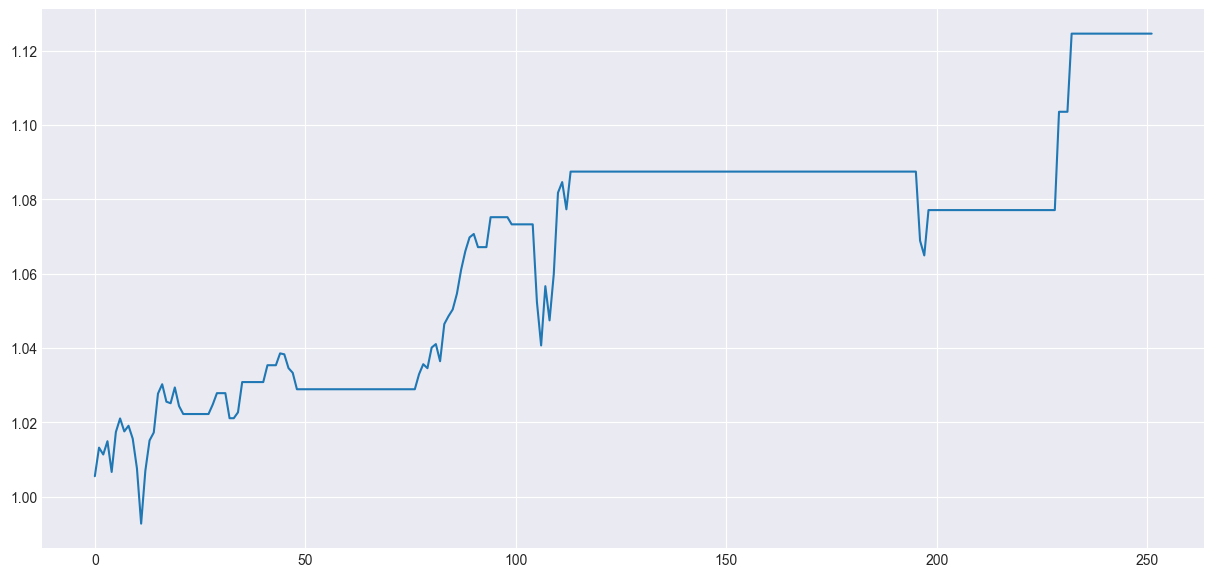

In [17]:
plt.figure(figsize=(15, 7))

# Multiply the future percentage returns with the signals generated to calculate the strategy's performance
strategy_perf1 = pd.Series(
    strategy_perf*data_sim.Close.pct_change().shift(-1).iloc[-simulation_length:].values)
plt.plot(np.nancumprod(strategy_perf1+1))

plt.show()

## Practice

You can try it yourself on a new data set and see how the simulation works. <br><br>